In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
from sklearn import datasets
from sklearn.metrics import silhouette_score
df = pd.read_csv('Sample-Superstore - Sample-Superstore.tsv', delimiter = "\t")

In [34]:
for col in df:
    df.rename(columns={col: col.lower().replace(' ', '').replace('-', '')}, inplace=True)

In [35]:
df.head()

,rowid,orderid,orderdate,shipdate,shipmode,customerid,customername,segment,country,city,...,postalcode,region,productid,category,subcategory,productname,sales,quantity,discount,profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [36]:
df_monetary = df.groupby('customerid')['sales'].sum()
df_monetary = df_monetary.reset_index()

In [37]:
df_frequency = df.groupby('customerid')['orderid'].count()
df_frequency = df_frequency.reset_index()
df_frequency.columns = ['customerid', 'order_count']

In [38]:
import datetime as dt

df['orderdate'] = pd.to_datetime(df['orderdate'])

# Calculate the most recent order date
most_recent_date = df['orderdate'].max()

# Subtract the order date from the most recent date
df_recency = df.groupby('customerid')['orderdate'].max().reset_index()
df_recency['recency'] = (most_recent_date - df_recency['orderdate']).dt.days
df_recency.drop('orderdate', axis=1, inplace=True)

In [39]:
df_combined = pd.merge(df_monetary, df_frequency, on='customerid')
df_combined = pd.merge(df_combined, df_recency, on='customerid')
df_combined.head()

,customerid,sales,order_count,recency
0,AA-10315,5563.560,11,184
1,AA-10375,1056.390,15,19
2,AA-10480,1790.512,12,259
3,AA-10645,5086.935,18,55
4,AB-10015,886.156,6,415


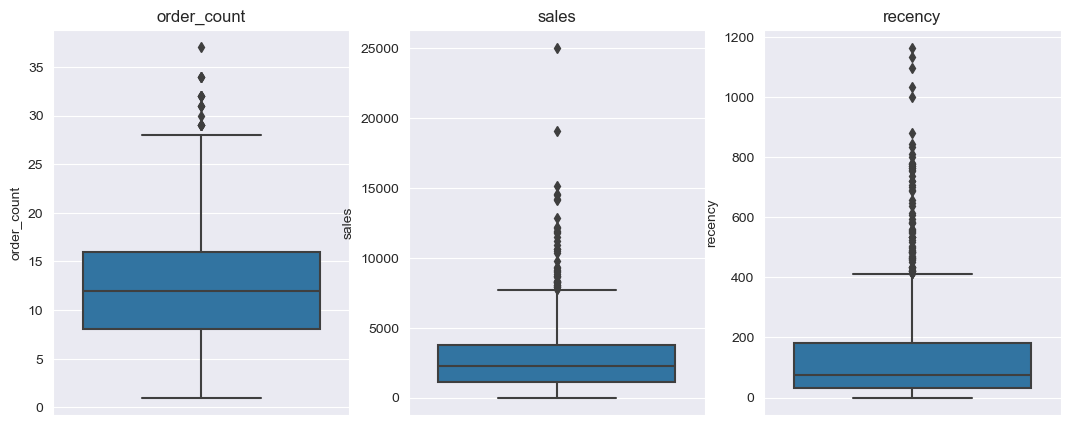

In [40]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 5))

sns.boxplot(y ='order_count', data=df_combined, ax=axes[0])
axes[0].set_title('order_count')

sns.boxplot(y='sales', data=df_combined , ax=axes[1])
axes[1].set_title('sales')

sns.boxplot(y='recency', data=df_combined , ax=axes[2])
axes[2].set_title('recency')

plt.show()

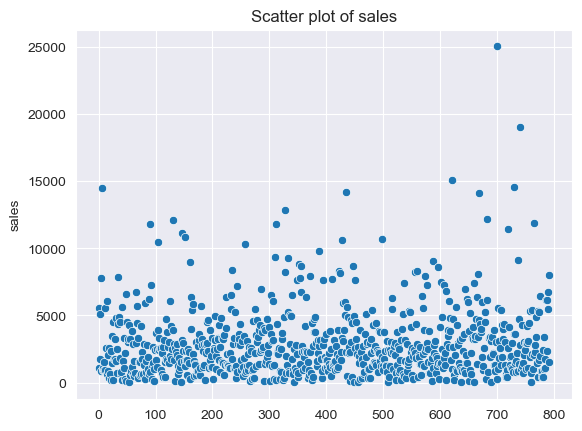

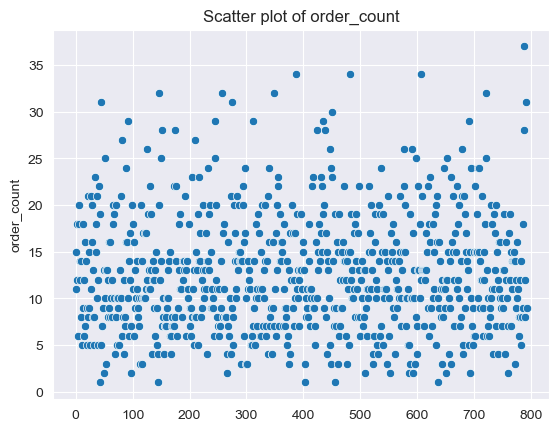

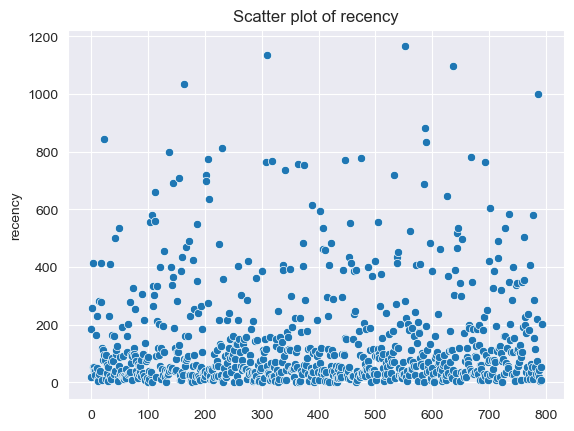

In [41]:
for column in df_combined.columns:
    if column != 'customerid':
        sns.scatterplot(data=df_combined[column])
        plt.ylabel(column)
        plt.title(f'Scatter plot of {column}')
        plt.show()

In [42]:
q1 =df_combined.quantile(0.25)
q3 =df_combined.quantile(0.75)
iqr = q3 - q1
df_combined =df_combined[~((df_combined < (q1 - 1.5 * iqr)) |(df_combined > (q3 + 1.5 * iqr))).any(axis=1)]

C:\Users\renev\AppData\Local\Temp\ipykernel_25024\4270230412.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_combined =df_combined[~((df_combined < (q1 - 1.5 * iqr)) |(df_combined > (q3 + 1.5 * iqr))).any(axis=1)]


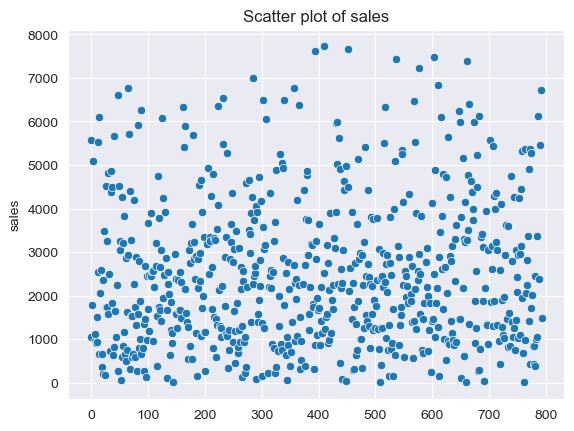

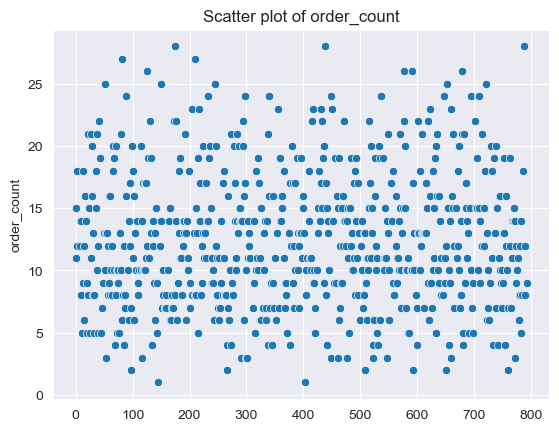

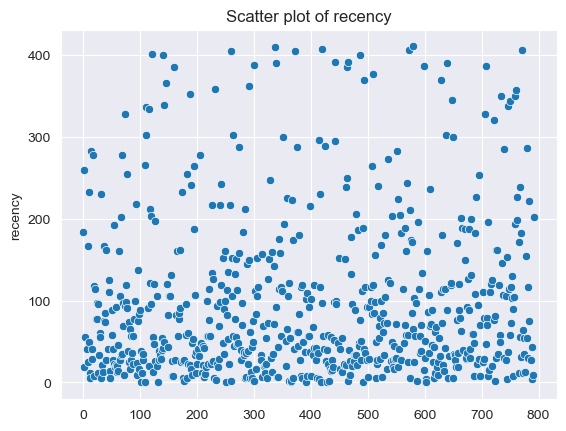

In [43]:
for column in df_combined.columns:
    if column != 'customerid':
        sns.scatterplot(data=df_combined[column])
        plt.ylabel(column)
        plt.title(f'Scatter plot of {column}')
        plt.show()

<AxesSubplot:ylabel='recency'>

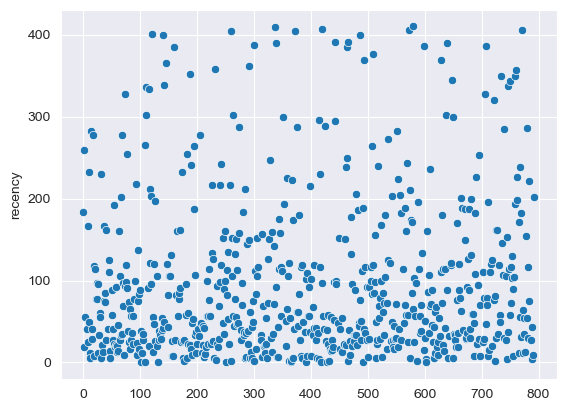

In [44]:
sns.scatterplot(data=df_combined['recency']) 

In [49]:
# Rescaling the attributes
rfm_df = df_combined[['sales', 'order_count', 'recency']]

scaler = StandardScaler()

# fit transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['sales', 'order_count', 'recency']
rfm_df_scaled.head()

,sales,order_count,recency
0,1.815723,-0.261677,0.876012
1,-0.863557,0.472007,-0.812704
2,-0.427160,-0.078256,1.643610
3,1.532394,1.022270,-0.444257
4,-0.916868,-0.078256,-0.587542


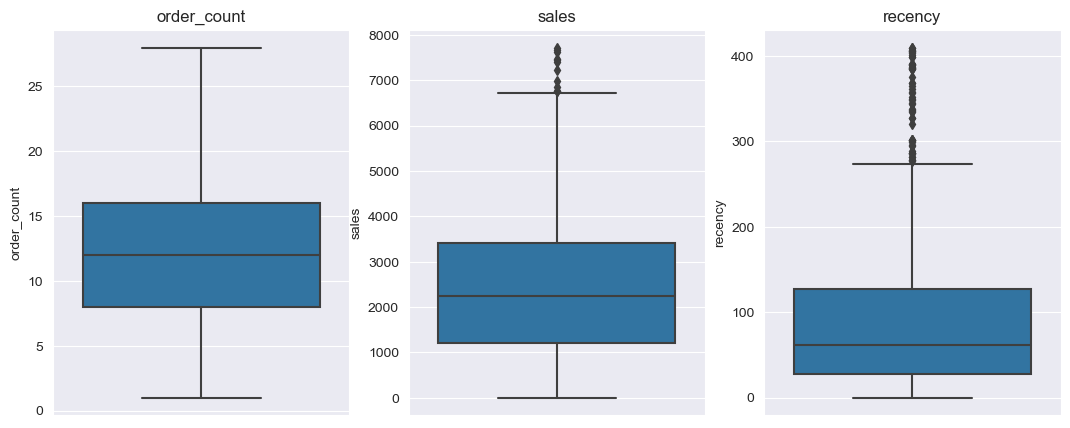

In [58]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 5))

sns.boxplot(y ='order_count', data=df_combined, ax=axes[0])
axes[0].set_title('order_count')

sns.boxplot(y='sales', data=df_combined , ax=axes[1])
axes[1].set_title('sales')

sns.boxplot(y='recency', data=df_combined , ax=axes[2])
axes[2].set_title('recency')

plt.show()

c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

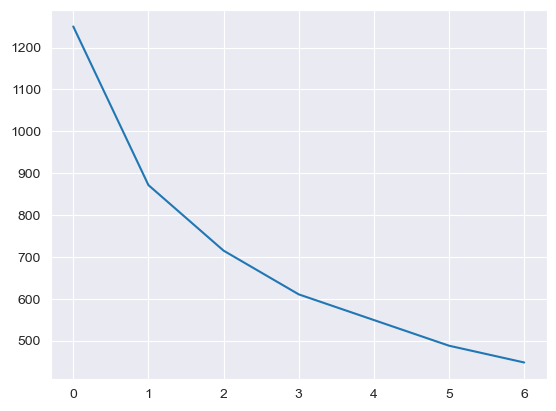

In [60]:
# Elbow-curve /SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)

plt.plot(ssd)

c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters=2, the silhouette score is 0.3400103700052583


c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters=3, the silhouette score is 0.3631067664773552


c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters=4, the silhouette score is 0.32113535480574684


c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters=5, the silhouette score is 0.32845273388567403


c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters=6, the silhouette score is 0.2779913572695638


c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters=7, the silhouette score is 0.2752906396763976


c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters=8, the silhouette score is 0.27475240810189544


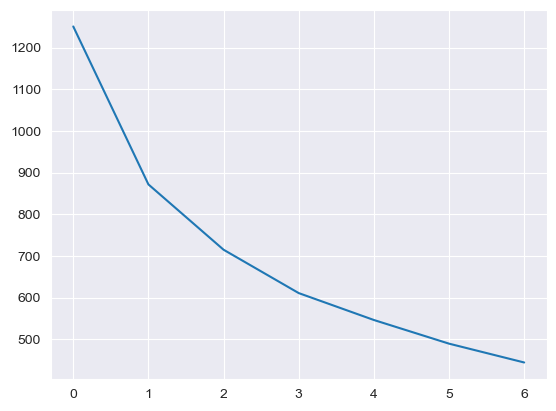

In [65]:
# Silhouette analysis
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    ssd.append(kmeans.inertia_)

plt.plot(ssd)

In [68]:
features = rfm_df_scaled[['sales', 'order_count', 'recency']]

# Create and fit the K-means model
kmeans = KMeans(n_clusters=4)  # K is the number of clusters you want to create
kmeans.fit(features)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_
sorted(Counter(cluster_labels).items())

# Get the centroids of each cluster
centroids = kmeans.cluster_centers_

# Print the cluster labels and centroids
print("Cluster Labels:")
print(cluster_labels)
print("\nCluster Centroids:")
print(centroids)

c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\renev\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Cluster Labels:
[0 2 3 0 1 1 1 1 3 0 2 3 0 2 3 1 1 1 2 2 1 0 1 2 2 1 0 3 1 0 0 0 1 1 1 0 2
 1 1 1 0 0 1 2 1 2 3 1 1 1 2 1 2 1 1 1 0 2 0 2 3 2 1 1 1 3 2 1 3 1 1 2 1 0
 1 1 2 1 1 0 2 1 3 1 2 2 1 1 2 1 2 1 2 2 1 2 3 3 3 1 2 3 3 0 3 2 3 2 1 2 0
 1 0 1 2 2 2 1 2 2 1 1 1 3 1 3 3 2 2 2 1 1 1 1 1 1 3 0 0 0 1 1 1 1 1 2 3 2
 2 2 1 0 2 3 2 1 2 3 2 3 2 2 2 0 3 3 2 1 1 2 1 1 1 0 2 1 2 2 1 2 1 0 2 2 2
 2 1 2 1 0 2 3 1 1 2 2 3 0 2 2 1 2 1 0 1 3 1 2 2 2 2 2 1 1 2 1 1 2 1 3 3 1
 2 1 3 1 1 1 1 2 1 1 1 0 1 3 1 0 2 2 3 1 0 3 0 2 2 2 2 2 3 2 2 2 0 1 2 2 2
 3 1 0 2 2 1 2 0 1 1 2 1 1 2 1 2 1 2 2 1 1 0 3 1 1 0 1 1 0 3 3 0 2 1 1 1 1
 2 1 1 1 3 3 0 1 2 3 2 2 2 2 0 1 3 1 1 1 3 2 3 2 2 0 0 2 2 1 1 1 2 2 2 1 1
 1 0 2 2 1 3 2 2 1 1 1 1 1 2 0 1 1 2 3 1 2 1 3 1 1 1 3 2 2 2 0 2 0 0 2 0 1
 0 2 1 2 3 3 0 2 1 0 0 0 1 2 1 2 1 2 3 3 3 3 1 1 2 0 1 2 2 1 1 1 2 2 2 3 0
 3 2 1 2 3 1 2 2 3 2 2 3 2 1 2 1 1 2 1 1 1 1 3 2 3 1 1 1 1 0 0 2 3 2 2 2 1
 1 1 2 2 1 1 1 1 1 0 0 1 0 2 1 1 3 2 1 0 1 2 0 1 3 2 3 2 3 0 3 1 2 1 3 1 1
 0 3 0 2 

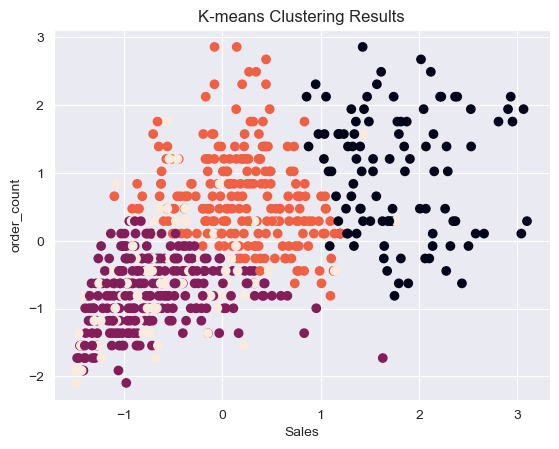

In [76]:
plt.scatter(rfm_df_scaled['sales'], rfm_df_scaled['order_count'], c=kmeans.labels_)
plt.xlabel('Sales')
plt.ylabel('order_count')
plt.title('K-means Clustering Results')
plt.show()